# Gate Segmentation

In [ ]:
#creating the final dataset with all the months and assigning a flight index to each flight within the final dataset (landing index is assigned to each flight within each month)
import pandas as pd
import glob

file_paths = sorted(glob.glob("*.csv")) 
all_dfs = []
next_index = 0

for path in file_paths:
    df = pd.read_csv(path, dtype={"ICAO": str})

    unique_landings = sorted(df["Landing_Index"].unique())
    mapping = {old: new for new, old in enumerate(unique_landings, start=next_index + 1)}
    df["Flight_Index"] = df["Landing_Index"].map(mapping)

    next_index += len(unique_landings)

    all_dfs.append(df)

full_df = pd.concat(all_dfs, ignore_index=True)
full_df.to_csv("all_months.csv", index=False)

In [ ]:
#gate segmentation (paper): 40 gates (0.25 NM) and interpolation, each gate has features
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d

gates_nm = np.linspace(10, 0.25, 40) 
n_gates = len(gates_nm)

static_features = ["Wind_Speed_M", "Wind_Gust_E", "Wind_Shear_E", "C_1000_E", "C_500_E", "WS_M", "FG_M", "RA_M", "G_M", "Wind_CompU_E", "Wind_CompV_E", "LOS", "GA_before", "GA_hourly", "GA_lasttime", "Speed_Diff_lt", "Alt_Diff_lt", "Lead_Aircraft"]

dynamic_features = ["Correct Altitude", "Speed", "Vertical Rate", "Glideslope", "Deviation", "Energy"]

all_features = static_features + dynamic_features
n_features = len(all_features)

df = full_df

X_per_flight, y_per_flight, mask_per_flight, ids_per_flight = [], [], [], []
examples_ga, examples_normal = [], []

for flight_index, flight_df in df.groupby("Flight_Index"):
    flight_label = flight_df["Go_Around_Label"].iloc[0]  
    flight_df = flight_df.sort_values("Distance_NM", ascending=True) 
    flight_df = flight_df.drop_duplicates(subset="Distance_NM", keep="first") 

    if flight_df.empty or flight_df["Distance_NM"].nunique() < 2: 
            continue

    #dynamic features (time dependent): interpolation for the 40 data points
    dynamic_sequence = []
    for feat in dynamic_features:
        try:
            f1 = interp1d(flight_df["Distance_NM"], flight_df[feat], kind="linear", bounds_error=False, fill_value=(flight_df[feat].iloc[0], flight_df[feat].iloc[-1]))
            y1 = f1(np.sort(gates_nm))   
            y1 = y1[::-1]  
        except Exception:
            y1 = np.full(n_gates, np.nan)
        dynamic_sequence.append(y1)
    dynamic_sequence = np.stack(dynamic_sequence , axis=1) #shape: (40, # dynamic features)

    #static features (time independent): all the gates have the same value
    static_vals = flight_df[static_features].iloc[0].values
    static_sequence = np.tile(static_vals, (n_gates, 1)) #shape: (40, # static features)

    full_sequence = np.hstack([static_sequence, dynamic_sequence]) 
    full_sequence = np.nan_to_num(full_sequence, nan=0.0) #shape: (40, # features)
    flight_mask = np.ones(n_gates, dtype=int)

    #ga flights
    if flight_label == 1:
        vertrate = full_sequence[:, all_features.index("Vertical Rate")]

        if np.all(vertrate >= 0):
            continue

        first_descent = np.where(vertrate < 0)[0]
        if len(first_descent) == 0:
            continue
        first_descent = first_descent[0]

        climb_after_descent = np.where((np.arange(len(vertrate)) >= first_descent) & (vertrate > 0))[0]
        if len(climb_after_descent) > 0:
            cut_start = climb_after_descent[0]
            full_sequence[cut_start:, :] = 0.0
            flight_mask[cut_start:] = 0

    #normal flights 
    if flight_label == 0: 
        vertrate = full_sequence[:, all_features.index("Vertical Rate")] 
        
        first_descent = np.where(vertrate < 0)[0]
        if len(first_descent) > 0:
            first_descent = first_descent[0]
            climb_after_descent = np.where((np.arange(len(vertrate)) >= first_descent) & (vertrate > 0))[0]
            if len(climb_after_descent) > 0:
                print(f"Skipping normal flight {flight_index} due to climb after descent")
                continue
    
    X_per_flight.append(full_sequence) 
    y_per_flight.append(flight_label) 
    mask_per_flight.append(flight_mask) 
    ids_per_flight.append(flight_index)

X = np.array(X_per_flight) #shape: (# flights, 20, # features) -> features
y = np.array(y_per_flight) #shape: (# flights,) -> unique per flight
masks = np.array(mask_per_flight) #shape: (# flights, 20) -> unique per gate
ids = np.array(ids_per_flight)

for i, feature in enumerate(all_features):
    values = X[:,:,i][masks == 1] 
    mean = np.mean(values)
    std = np.std(values)
    min_val = np.min(values)
    max_val = np.max(values)
    print(f"{feature}: mean={mean:.2f}, std={std:.2f}, min={min_val:.2f}, max={max_val:.2f}")

In [ ]:
from sklearn.model_selection import train_test_split

#train, validation (70/20/10)
#stratify ensures equal separation btw normal landings and gas
#split 1: 90% to train and val and 10% to test
X_temp, X_test_real, y_temp, y_test, m_temp, m_test, ids_temp, ids_test = train_test_split(X, y, masks, ids, stratify=y, test_size=0.1, random_state=42)

#split 2: 70% to train and 20% to set
X_train, X_val, y_train, y_val, m_train, m_val, ids_train, ids_val = train_test_split(X_temp, y_temp, m_temp, ids_temp, stratify=y_temp, test_size=2/9, random_state=42)

for i, feature in enumerate(all_features):
    values = X_train[:,:,i][m_train == 1] 
    mean = np.mean(values)
    std = np.std(values)
    min_val = np.min(values)
    max_val = np.max(values)
    print(f"{feature}: mean={mean:.2f}, std={std:.2f}, min={min_val:.2f}, max={max_val:.2f}")

#data normalization
scaler = StandardScaler()
#X_train shape: (# flights, 40, # features)
#m_train shape: (# flights, 40) - which gates are real and which ones are padding
X_train_flat = X_train[m_train == 1].reshape(-1, n_features) #just the gates that are being used (not padded)
scaler.fit(X_train_flat) #learns the parameters (mean and std)

#scalers work with 2D arrays (# samples, # features)
def scale_and_reshape(X, mask):
    X_flat = X.reshape(-1, n_features) #shape: (# flights*40, # features)
    X_scaled = X_flat.copy()
    masked_indices = mask.flatten() == 1 #mask.flatten() shape: (# flights*40)
    X_scaled[masked_indices] = scaler.transform(X_flat[masked_indices])
    return X_scaled.reshape(X.shape)

X_train = scale_and_reshape(X_train, m_train)
X_test = scale_and_reshape(X_test_real, m_test)
X_val = scale_and_reshape(X_val, m_val)

summary = {
    "X_train_shape": X_train.shape,
    "X_val_shape": X_val.shape,
    "X_test_shape": X_test.shape,
    "y_train_shape": y_train.shape,
    "y_val_shape": y_val.shape,
    "y_test_shape": y_test.shape,
    "m_train_shape": m_train.shape,
    "m_val_shape": m_val.shape,
    "m_test_shape": m_test.shape,
    "mask_shape": masks.shape,
}

num_examples = 5
ga_indices = [i for i, y in enumerate(y_per_flight) if y == 1]

for i in ga_indices[:num_examples]:
    flight_index = ids_per_flight[i]
    flight_sequence = X_per_flight[i]
    flight_mask = mask_per_flight[i]
    example_df = pd.DataFrame(flight_sequence, columns=all_features, index=[f"{g:.2f}NM" for g in gates_nm])
    example_df["Mask"] = flight_mask  

    print(f"\n--- GA Flight {flight_index} ---")
    print(example_df)

normal_indices = [i for i, y in enumerate(y_per_flight) if y == 0]

for i in normal_indices[:num_examples]:
    flight_index = ids_per_flight[i]
    flight_sequence = X_per_flight[i]
    flight_mask = mask_per_flight[i]
    example_df = pd.DataFrame(flight_sequence, columns=all_features, index=[f"{g:.2f}NM" for g in gates_nm])
    example_df["Mask"] = 1

    print(f"\n--- NORMAL Flight {flight_index} ---")
    print(example_df)

In [ ]:
num_gas = sum(y_per_flight)             
num_normals = len(y_per_flight) - num_gas

print(f"Number of GA flights: {num_gas}")
print(f"Number of normal flights: {num_normals}")

Number of GA flights: 1147
Number of normal flights: 240771


In [ ]:
import pandas as pd
import numpy as np

def describe_normalized(X, mask, feature_names=None):
    X_real = X[mask == 1].reshape(-1, X.shape[-1])
    df = pd.DataFrame(X_real, columns=feature_names if feature_names else [f"f{i}" for i in range(X_real.shape[1])])
    summary = df.describe().T[["mean", "std", "min", "max"]]
    return summary
summary_train = describe_normalized(X_train, m_train, feature_names=all_features)
print(summary_train)

In [ ]:
summary

In [ ]:
#checkar a divisao de gas e voos normais pelo train, val and test set
def count_goarounds(y_split, name=""):
    binary_labels = y_split
    n_gas = np.sum(binary_labels)
    n_normals = len(binary_labels) - n_gas
    print(f"{name} set:")
    print(f"Go-arounds: {n_gas}")
    print(f"Normal:     {n_normals}")
    print(f"Total:      {len(binary_labels)}\n")

count_goarounds(y_train, "Train")
count_goarounds(y_val, "Validation")
count_goarounds(y_test, "Test")

#### ----------------------------------------------------------

# Models

#### tuning hyperparameters

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, TimeDistributed, Dense, MultiHeadAttention
from tensorflow.keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

#reshape y because the time distributed layer expects shape: (#flights, 40, #label) instead of just (#flights, 40), time distributed layer outputs aprobablity each gate
y_train_reshaped = np.tile(y_train[:, None], (1, X_train.shape[1]))[..., np.newaxis] #(n_train, 40, 1)
y_val_reshaped   = np.tile(y_val[:, None],   (1, X_val.shape[1]))[..., np.newaxis] #(n_val, 40, 1)
y_test_reshaped  = np.tile(y_test[:, None],  (1, X_test.shape[1]))[..., np.newaxis] #(n_test, 40, 1)

def tuning_lstm_model(hp):
    
    #hyperparameters
    lstm_units = hp.Choice('lstm_units', [128, 256]) 
    dense_units = hp.Choice('dense_units', [64, 128, 256]) 
    dropout_rate = hp.Choice('dropout_rate', [0.0, 0.1, 0.2]) 
    activation_fn = hp.Choice('activation',['ReLU', 'tanh', 'swish'])
    learning_rate = hp.Choice('learning_rate', [0.01, 0.001])
    attention_heads = hp.Choice('attention_heads', [2, 4, 8])
    loss_fn = hp.Choice('loss', ['bce', 'bfl'])
    #batch = hp.Choice('batch_size', [64, 128, 256, 512])
    
    #layers
    input_shape=(X_train.shape[1], X_train.shape[2])
    inp = Input(shape=input_shape)
    x = Masking(mask_value=0.0)(inp)
    x = LSTM(lstm_units, return_sequences=True)(x)
    attn = MultiHeadAttention(num_heads=attention_heads, key_dim=lstm_units)(x, x)
    x = Dropout(dropout_rate)(attn)
    x = TimeDistributed(Dense(dense_units, activation=activation_fn))(x)
    out = TimeDistributed(Dense(1, activation='sigmoid'))(x)
    model = Model(inputs=inp, outputs=out)
    
    #loss
    if loss_fn == 'bce':
        loss = BinaryCrossentropy() #standard cross entropy for binary labels
    else:
        loss = BinaryFocalCrossentropy(alpha=0.95, gamma=1) #focal loss 
        #alpha = 0.95: weights the minority class
        #gamma = 1: focuses training on the hard to classify samples
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model

In [ ]:
import os

#create a directory (windows)
tuner_dir = os.path.normpath("C:/Users/anafi/tuner5")
os.makedirs(tuner_dir, exist_ok=True)

#setup tuner: random search
tuner = kt.RandomSearch(
    tuning_lstm_model,
    objective='val_precision', #tries to maximize the validation precision  TENTAR O F1 OR F2
    max_trials=10, #runs 50 different sampled hyperparameter trials (50 models)             
    executions_per_trial=2, #trains each sampled hyperparameters twice     
    directory=tuner_dir,
    project_name='lstm'
)
tuner.search_space_summary()

In [ ]:
#early stopping 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#search tuner
tuner.search(
    X_train, y_train_reshaped,
    validation_data=(X_val, y_val_reshaped),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop]
)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"LSTM units: {best_hps.get('lstm_units')}")
print(f"Dense units: {best_hps.get('dense_units')}")
print(f"Dropout rate: {best_hps.get('dropout_rate')}")
print(f"Activation: {best_hps.get('activation')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")
print(f"Attention heads: {best_hps.get('attention_heads')}")
print(f"Loss: {best_hps.get('loss')}")

best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
tuner.results_summary()

#test the best model with test set
best_model.evaluate(X_test, y_test_reshaped)

#retrain best model on train + validation sets
best_hp = tuner.get_best_hyperparameters(1)[0]
final_model = tuning_lstm_model(best_hp)  
final_model.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train_reshaped, y_val_reshaped]), epochs=20, batch_size=64, callbacks=[early_stop]) 
final_model.evaluate(X_test, y_test_reshaped)

#### ----------------------------------------------------------

#### training + testing

##### model1: LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryFocalCrossentropy

bfl = BinaryFocalCrossentropy(alpha=0.95, gamma=1)

def build_lstm_model(input_shape, lstm_units=128, dense_units=256, dropout_rate=0.1):
    inp = Input(shape=input_shape)
    x = Masking(mask_value=0.0)(inp) 
    x = LSTM(lstm_units, return_sequences=True)(x) 
    x = Dropout(dropout_rate)(x) 
    x = TimeDistributed(Dense(dense_units, activation='relu'))(x) 
    out = TimeDistributed(Dense(1, activation='sigmoid'))(x) 

    model = Model(inputs=inp, outputs=out)
    model.compile( 
        optimizer=Adam(learning_rate=0.001),
        loss=bfl,
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')])
    return model

In [ ]:
y_train_reshaped = np.tile(y_train[:, None], (1, X_train.shape[1]))[..., np.newaxis] 
y_val_reshaped   = np.tile(y_val[:, None],   (1, X_val.shape[1]))[..., np.newaxis]   
y_test_reshaped  = np.tile(y_test[:, None],  (1, X_test.shape[1]))[..., np.newaxis]

model1 = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), lstm_units=128, dense_units=256, dropout_rate=0.2)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model1.fit(
    X_train, y_train_reshaped,
    validation_data=(X_val, y_val_reshaped),
    epochs=50, 
    batch_size=64, 
    callbacks=[early_stop],
    verbose=1)

model1.evaluate(X_test, y_test_reshaped)

In [ ]:
model1.save('model1.keras')

#### ----------------------------------------------------------

##### model2: Bi-LSTM


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, TimeDistributed, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryFocalCrossentropy

bfl = BinaryFocalCrossentropy(alpha=0.95, gamma=1)

def build_lstm_model(input_shape, lstm_units=128, dense_units=256, dropout_rate=0.1):
    inp = Input(shape=input_shape) 
    x = Masking(mask_value=0.0)(inp)
    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x) 
    x = Dropout(dropout_rate)(x) 
    x = TimeDistributed(Dense(dense_units, activation='relu'))(x) 
    out = TimeDistributed(Dense(1, activation='sigmoid'))(x)

    model = Model(inputs=inp, outputs=out)
    model.compile( 
        optimizer=Adam(learning_rate=0.001),
        loss=bfl,
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')])
    return model

In [ ]:
y_train_reshaped = np.tile(y_train[:, None], (1, X_train.shape[1]))[..., np.newaxis]  
y_val_reshaped   = np.tile(y_val[:, None],   (1, X_val.shape[1]))[..., np.newaxis]   
y_test_reshaped  = np.tile(y_test[:, None],  (1, X_test.shape[1]))[..., np.newaxis]

model2 = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), lstm_units=128, dense_units=256, dropout_rate=0.2)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model2.fit(
    X_train, y_train_reshaped,
    validation_data=(X_val, y_val_reshaped),
    epochs=50, 
    batch_size=64,
    callbacks=[early_stop],
    verbose=1)

model2.evaluate(X_test, y_test_reshaped)

In [ ]:
model2.save('model2.keras')

#### ----------------------------------------------------------

##### model3: GRU


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, TimeDistributed, Dense, MultiHeadAttention, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryFocalCrossentropy

bfl = BinaryFocalCrossentropy(alpha=0.95, gamma=1)

def build_lstm_model(input_shape, gru_units=128, dense_units=256, dropout_rate=0.1):
    inp = Input(shape=input_shape) 
    x = Masking(mask_value=0.0)(inp) 
    x = GRU(gru_units, return_sequences=True)(x) 
    x = Dropout(dropout_rate)(x) 
    x = TimeDistributed(Dense(dense_units, activation='relu'))(x) 
    out = TimeDistributed(Dense(1, activation='sigmoid'))(x) 

    model = Model(inputs=inp, outputs=out)
    model.compile( 
        optimizer=Adam(learning_rate=0.001),
        loss=bfl,
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')])
    return model

In [ ]:
y_train_reshaped = np.tile(y_train[:, None], (1, X_train.shape[1]))[..., np.newaxis]  # (n_train, 20, 1)
y_val_reshaped   = np.tile(y_val[:, None],   (1, X_val.shape[1]))[..., np.newaxis]    # (n_val, 20, 1)
y_test_reshaped  = np.tile(y_test[:, None],  (1, X_test.shape[1]))[..., np.newaxis]   # (n_test, 20, 1)

model3 = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), gru_units=128, dense_units=256, dropout_rate=0.1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model3.fit(
    X_train, y_train_reshaped,
    validation_data=(X_val, y_val_reshaped),
    epochs=50, 
    batch_size=64,
    callbacks=[early_stop],
    verbose=1)

model3.evaluate(X_test, y_test_reshaped)

In [ ]:
model3.save('model3.keras')

#### ----------------------------------------------------------

##### model4: LSTM + attention


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, TimeDistributed, Dense, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryFocalCrossentropy

bfl = BinaryFocalCrossentropy(alpha=0.95, gamma=1)

def build_lstm_model(input_shape, lstm_units=128, dense_units=128, dropout_rate=0.1):
    inp = Input(shape=input_shape)
    x = Masking(mask_value=0.0)(inp)
    x = LSTM(lstm_units, return_sequences=True)(x)
    attn = MultiHeadAttention(num_heads=4, key_dim=lstm_units)(x, x)
    x = Dropout(dropout_rate)(attn)
    x = TimeDistributed(Dense(dense_units, activation='relu'))(x)
    out = TimeDistributed(Dense(1, activation='sigmoid'))(x)

    model = Model(inputs=inp, outputs=out)
    model.compile( 
        optimizer=Adam(learning_rate=0.001),
        loss=bfl,
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')])
    return model

In [ ]:
y_train_reshaped = np.tile(y_train[:, None], (1, X_train.shape[1]))[..., np.newaxis]  # (n_train, 20, 1)
y_val_reshaped   = np.tile(y_val[:, None],   (1, X_val.shape[1]))[..., np.newaxis]    # (n_val, 20, 1)
y_test_reshaped  = np.tile(y_test[:, None],  (1, X_test.shape[1]))[..., np.newaxis]   # (n_test, 20, 1)

model4 = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), lstm_units=128, dense_units=128, dropout_rate=0.1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model4.fit(
    X_train, y_train_reshaped,
    validation_data=(X_val, y_val_reshaped),
    epochs=50, 
    batch_size=64, 
    callbacks=[early_stop],
    verbose=1)

model4.evaluate(X_test, y_test_reshaped)

In [ ]:
model4.save('model4.keras')

In [ ]:
from tensorflow import keras
model4 = keras.models.load_model("model4.keras")

In [ ]:
#plot: precision recall vs threshold and precision recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

y_val_pred = model4.predict(X_val)
y_val_pred = y_val_pred.squeeze(-1) 
print("y_val_pred shape:", y_val_pred.shape)

probs = y_val_pred[m_val == 1].flatten() 
true  = y_val_reshaped[m_val == 1].flatten() 

precision, recall, threshold = precision_recall_curve(true, probs)

plt.figure(figsize=(8,5))
plt.plot(threshold, precision[:-1], label="Precision", color="blue")
plt.plot(threshold, recall[:-1], label="Recall", color="orange")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold (valid gates only)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(recall, precision, color="purple")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP={average_precision_score(true, probs):.4f})")
plt.grid(True)
plt.show()

In [ ]:
#calculate the best thresholds (max f1 score) for each gate
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
import numpy as np

y_val_pred_prob = model4.predict(X_val)  
y_val_pred_prob = y_val_pred_prob.squeeze(-1)  

best_thresholds = []

for gate in range(y_val_pred_prob.shape[1]):
    y_true_gate = y_val_reshaped[:, gate, 0] #true labels
    y_prob_gate = y_val_pred_prob[:, gate] #predicated labels  
    
    thresholds = np.arange(0.0, 1.0, 0.001)  
    f1_scores, f2_scores, precisions, recalls = [], [], [], []
    
    for t in thresholds:
        y_pred_gate = (y_prob_gate >= t).astype(int)
        f1 = f1_score(y_true_gate, y_pred_gate, zero_division=0)
        f2 = fbeta_score(y_true_gate, y_pred_gate, beta=2, zero_division=0)
        prec = precision_score(y_true_gate, y_pred_gate, zero_division=0)
        rec = recall_score(y_true_gate, y_pred_gate, zero_division=0)
        
        f1_scores.append(f1)
        f2_scores.append(f2)
        precisions.append(prec)
        recalls.append(rec)
    
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_thresholds.append(best_threshold)
    
    print(
        f"Gate {gate+1}: "
        f"Best threshold = {best_threshold:.3f}, "
        f"F1 = {f1_scores[best_idx]:.4f}, "
        f"F2 = {f2_scores[best_idx]:.4f}, "
        f"Precision = {precisions[best_idx]:.4f}, "
        f"Recall = {recalls[best_idx]:.4f}")

In [ ]:
#calculate the confusion matrix for each gate
from sklearn.metrics import confusion_matrix

for gate in range(y_val_pred_prob.shape[1]):
    y_true_gate = y_val_reshaped[:, gate, 0]
    y_prob_gate = y_val_pred_prob[:, gate]
    
    threshold = best_thresholds[gate]
    y_pred_gate = (y_prob_gate >= threshold).astype(int)
    
    cm = confusion_matrix(y_true_gate, y_pred_gate)
    print(f"Gate {gate+1} confusion matrix:")
    print(cm)

In [ ]:
#calculate the importance matrix for global analysis

#function: computes the permutation importance, each feature is shuffled randomly at each gate 5 times
def global_permutation_importance(model, X_test, y_test, n_iter=5, gates=None, random_state=42):

    random = np.random.default_rng(random_state)
    n_samples, n_gates, n_features = X_test.shape
    if gates is None:
        gates = list(range(n_gates))

    bfl = BinaryFocalCrossentropy(alpha=0.95, gamma=1)

    y_pred = model.predict(X_test, verbose=0)
    original_loss = bfl(y_test, y_pred).numpy()

    importance_matrix = np.zeros((n_features, len(gates)))

    for gate_idx, g in enumerate(gates):
        print(f"Processing gate {g+1}/{n_gates}")

        for feature_idx in range(n_features):
            scores = []
            for _ in range(n_iter):
                X_permutation = X_test.copy()
                shuffled = random.permutation(X_permutation[:, g, feature_idx])
                X_permutation[:, g, feature_idx] = shuffled

                y_pred_permutation = model.predict(X_permutation, verbose=0)
                permutation_loss = bfl(y_test, y_pred_permutation).numpy()

                scores.append(original_loss - permutation_loss)
            importance_matrix[feature_idx, gate_idx] = np.mean(scores)

    return importance_matrix

y_test_reshaped  = np.tile(y_test[:, None],  (1, X_test.shape[1]))[..., np.newaxis]
print(y_test_reshaped.shape)
print(X_test.shape)

subset_gates = [0, 5, 10, 15]  
importance_matrix = global_permutation_importance(model4, X_test, y_test_reshaped, n_iter=5, gates=subset_gates)
print("Importance matrix shape:", importance_matrix.shape)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#function: plots the top 10 features per gate - globally
def plot_global_analysis(importance_matrix, feature_names, gate_labels, original_loss, top_features=10, figsize=(10, 6)):
    importance_matrix_relative = (importance_matrix / original_loss) * 100
    importance_df = pd.DataFrame(importance_matrix_relative, index=feature_names, columns=gate_labels)
    for gate in importance_df.columns:
        df_sorted = (importance_df[gate].sort_values(ascending=True) .tail(top_features).reset_index())
        df_sorted.columns = ["Feature", "Importance (%)"]

        plt.figure(figsize=figsize)
        sns.barplot(data=df_sorted, x="Importance (%)", y="Feature", color="royalblue")
        plt.xlabel("Relative Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    return importance_df 

feature_names = all_features
gate_labels = [f"Gate {g}" for g in subset_gates]

y_test_pred = model4.predict(X_test, verbose=0)
bfl = BinaryFocalCrossentropy(alpha=0.95, gamma=1)
original_loss = bfl(y_test_reshaped, y_test_pred).numpy()

importance_df_relative = plot_global_analysis(importance_matrix, feature_names, gate_labels, original_loss, top_features=10, figsize=(10, 6))

In [ ]:
#calculate the importance matrix for local interpretability 
import numpy as np

#function: receives delta which is how far a feature is from its mean, applies different transformations depending on the feature type
def feature_function(delta, feature_name):
    #binary indicators
    if feature_name in ["WS_M", "FG_M", "RA_M", "G_M", "GA_before", "Lead_Aircraft"]:
        return 1 if delta > 0 else 0

    #absolute deviations
    if feature_name in ["Wind_Speed_M", "Wind_Gust_E", "Wind_Shear_E", "Deviation", "Energy", "GA_hourly", "GA_lasttime", "C_1000_E", "C_500_E", "Wind_CompU_E", "Wind_CompV_E", "Speed","Correct Altitude", "Vertical Rate","Glideslope"]:
        return abs(delta)

    #negative deviations (higher = less risk)
    if feature_name in ["Speed_Diff_lt", "Alt_Diff_lt"]:
        return min(0, delta)
    
    #positive deviations (lower = less risk)
    if feature_name in ["LOS"]:
        return max(0, delta)

    return delta

#function: computes the local importance of each feature 
def local_permutation_importance(X_test, means, stds, global_matrix, feature_names, flight_idx, gates=None):

    n_samples, n_gates, n_features = X_test.shape
    if gates is None:
        gates = list(range(n_gates))

    contribution_matrix = np.zeros((n_features, len(gates)))
    normalized_contribution = np.zeros_like(contribution_matrix) 

    for gate_idx, g in enumerate(gates):

        for f, feature_idx in enumerate(feature_names):  
            value = X_test[flight_idx, g, f]
            mean, std = means[f], stds[f]
            delta = (value - mean) / (std if std > 0 else 1) 

            feature_val = feature_function(delta, feature_idx)
            beta = gates.index(gate_idx)
            contribution_matrix[f, gate_idx] = feature_val * max(0, global_matrix[f, beta]) 

        denominator = contribution_matrix[:, gate_idx].sum()
        if denominator > 0:
           normalized_contribution[:, gate_idx] = contribution_matrix[:, gate_idx] / denominator * 100

    return contribution_matrix, normalized_contribution

flight_idx = 2184 #true positive, change for the false positive, true negative and false negative
#tp_idx = 2184 - yellowgreen
#tn_idx = 4 - royalblue
#fp_idx = 7687 - orange
#fn_idx = 1016 - tomato

importance_df = pd.DataFrame(importance_matrix, index=feature_names, columns=gate_labels)
global_matrix = importance_df.to_numpy() 
means = X_test.mean(axis=(0, 1))   
stds = X_test.std(axis=(0, 1))

contribution_matrix, normalized_contribution = local_permutation_importance(X_test, means, stds, global_matrix, all_features, flight_idx, gates=subset_gates)

gate = 0
gate_pos = subset_gates.index(gate) 

df_local = pd.DataFrame({"Feature": all_features, "Contribution matrix": contribution_matrix[:, gate_pos], "Normalized contribution (%)": normalized_contribution[:, gate_pos]}).sort_values("Normalized contribution (%)", ascending=False)
print(df_local.head(10))

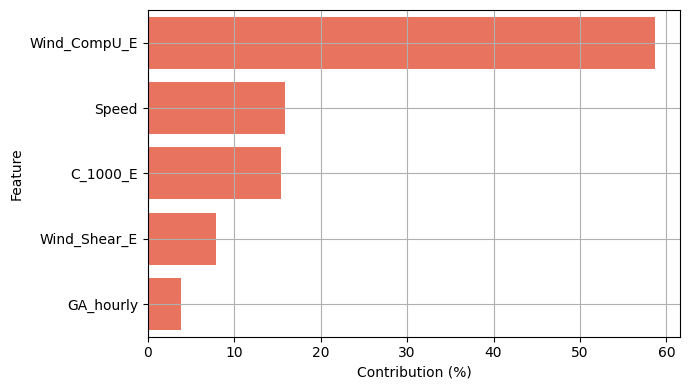

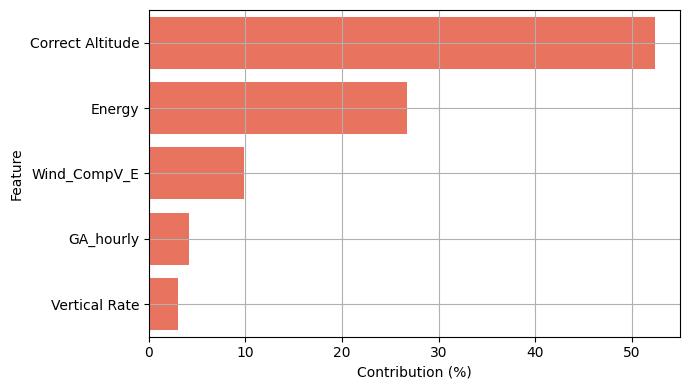

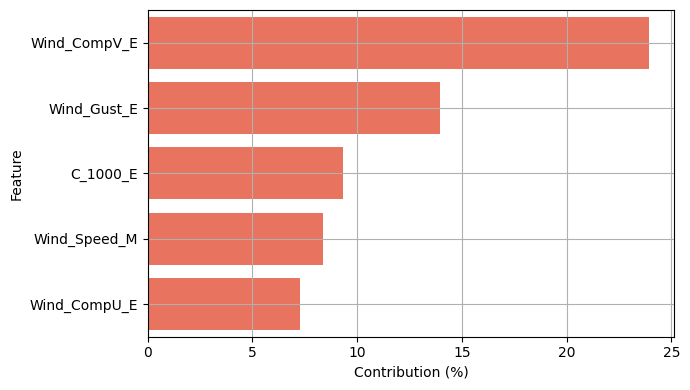

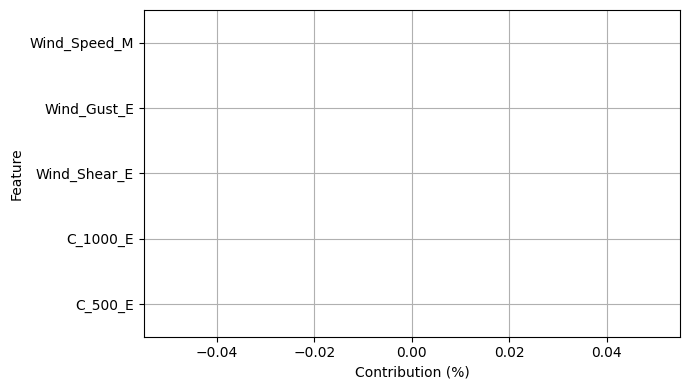

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#function: plots the top 5 features per gate - locally
def plot_local_interpretability(alpha, feature_names, gates, top_features=5):

    for g_idx, g_real in enumerate(gates):
        df = pd.DataFrame({
            "Feature": feature_names,
            "Alpha (%)": alpha[:, g_idx]  
        }).sort_values("Alpha (%)", ascending=False).head(top_features)

        plt.figure(figsize=(7, 4))
        sns.barplot(data=df, x="Alpha (%)", y="Feature", color="tomato")
        plt.xlabel("Contribution (%)")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.grid(True)
        plt.show()

contribution_matrix, normalized_contribution = local_permutation_importance(X_test, means, stds, global_matrix, feature_names, flight_idx=1016, gates=subset_gates)

plot_local_interpretability(normalized_contribution, feature_names, subset_gates, top_features=5)

#### ----------------------------------------------------------

##### model5: Bi-LSTM + attention


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, TimeDistributed, Dense, MultiHeadAttention, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryFocalCrossentropy

bfl = BinaryFocalCrossentropy(alpha=0.95, gamma=1)

def build_bilstm_model(input_shape, lstm_units=128, dense_units=256, dropout_rate=0.1):
    inp = Input(shape=input_shape)
    x = Masking(mask_value=0.0)(inp)
    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    attn = MultiHeadAttention(num_heads=4, key_dim=(lstm_units))(x, x)
    x = Dropout(dropout_rate)(attn)
    x = TimeDistributed(Dense(dense_units, activation='relu'))(x) 
    out = TimeDistributed(Dense(1, activation='sigmoid'))(x)

    model = Model(inputs=inp, outputs=out)
    model.compile( 
        optimizer=Adam(learning_rate=0.001),
        loss=bfl,
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')])
    return model

In [ ]:
y_train_reshaped = np.tile(y_train[:, None], (1, X_train.shape[1]))[..., np.newaxis]  
y_val_reshaped   = np.tile(y_val[:, None],   (1, X_val.shape[1]))[..., np.newaxis]   
y_test_reshaped  = np.tile(y_test[:, None],  (1, X_test.shape[1]))[..., np.newaxis] 

model5 = build_bilstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), lstm_units=128, dense_units=256, dropout_rate=0.2)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model5.fit(
    X_train, y_train_reshaped,
    validation_data=(X_val, y_val_reshaped),
    epochs=50, 
    batch_size=64,
    callbacks=[early_stop],
    verbose=1)

model5.evaluate(X_test, y_test_reshaped)

In [ ]:
model5.save('model5.keras')

#### ----------------------------------------------------------

##### model6: GRU + attention

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, TimeDistributed, Dense, MultiHeadAttention, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryFocalCrossentropy

bfl = BinaryFocalCrossentropy(alpha=0.95, gamma=1)

def build_lstm_model(input_shape, lstm_units=128, dense_units=256, dropout_rate=0.1):
    inp = Input(shape=input_shape) 
    x = Masking(mask_value=0.0)(inp) 
    x = GRU(lstm_units, return_sequences=True)(x) 
    attn = MultiHeadAttention(num_heads=4, key_dim=lstm_units)(x, x)
    x = Dropout(dropout_rate)(attn) 
    x = TimeDistributed(Dense(dense_units, activation='relu'))(x)
    out = TimeDistributed(Dense(1, activation='sigmoid'))(x)

    model = Model(inputs=inp, outputs=out)
    model.compile( 
        optimizer=Adam(learning_rate=0.001),
        loss=bfl,
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')])
    return model

In [ ]:
y_train_reshaped = np.tile(y_train[:, None], (1, X_train.shape[1]))[..., np.newaxis]  
y_val_reshaped   = np.tile(y_val[:, None],   (1, X_val.shape[1]))[..., np.newaxis]  
y_test_reshaped  = np.tile(y_test[:, None],  (1, X_test.shape[1]))[..., np.newaxis]   

model6 = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), lstm_units=128, dense_units=256, dropout_rate=0.2)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model6.fit(
    X_train, y_train_reshaped,
    validation_data=(X_val, y_val_reshaped),
    epochs=50, 
    batch_size=64, 
    callbacks=[early_stop],
    verbose=1)

model6.evaluate(X_test, y_test_reshaped)

In [ ]:
model6.save('model6.keras')

#### ----------------------------------------------------------

#### Data analysis + plots

In [ ]:
y_train_reshaped = np.tile(y_train[:, None], (1, X_train.shape[1]))[..., np.newaxis] 
y_val_reshaped   = np.tile(y_val[:, None],   (1, X_val.shape[1]))[..., np.newaxis] 
y_test_reshaped  = np.tile(y_test[:, None],  (1, X_test.shape[1]))[..., np.newaxis] 

print(y_test.shape)
print(y_test_reshaped.shape)
print(X_test.shape)

(24055,)
(24055, 40, 1)
(24055, 40, 24)


In [ ]:
#find the best thresholds for each of the models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
import tensorflow as tf

models = {
    "LSTM": tf.keras.models.load_model("model1.keras"),
    "Bi-LSTM": tf.keras.models.load_model("model2.keras"),
    "GRU": tf.keras.models.load_model("model3.keras"),
    "LSTM + attention": tf.keras.models.load_model("model4.keras"),
    "Bi-LSTM + attention": tf.keras.models.load_model("model5.keras"),
    "GRU + attention": tf.keras.models.load_model("model6.keras"),
}

n_gates = 40
threshold_candidates = np.arange(0.0, 1.0, 0.001)
best_thresholds = {name: [] for name in models.keys()}

for name, model in models.items():
    y_val_pred_prob = model.predict(X_val).squeeze(-1) 
    
    for gate in range(n_gates):
        y_true_gate = y_val_reshaped[:, gate, 0]
        y_prob_gate = y_val_pred_prob[:, gate]

        f1_scores = []
        for t in threshold_candidates:
            y_pred_gate = (y_prob_gate >= t).astype(int)
            f1 = f1_score(y_true_gate, y_pred_gate, zero_division=0)
            f1_scores.append(f1)

        best_idx = np.argmax(f1_scores)
        best_thresholds[name].append(threshold_candidates[best_idx])


f1_model = {name: [] for name in models.keys()}
for name, model in models.items():
    y_test_pred_prob = model.predict(X_test).squeeze(-1)

    for gate in range(n_gates):
        y_true_gate = y_test_reshaped[:, gate, 0]
        threshold = best_thresholds[name][gate]
        y_pred_gate = (y_test_pred_prob[:, gate] >= threshold).astype(int)

        f1 = f1_score(y_true_gate, y_pred_gate, zero_division=0)
        f1_model[name].append(f1)

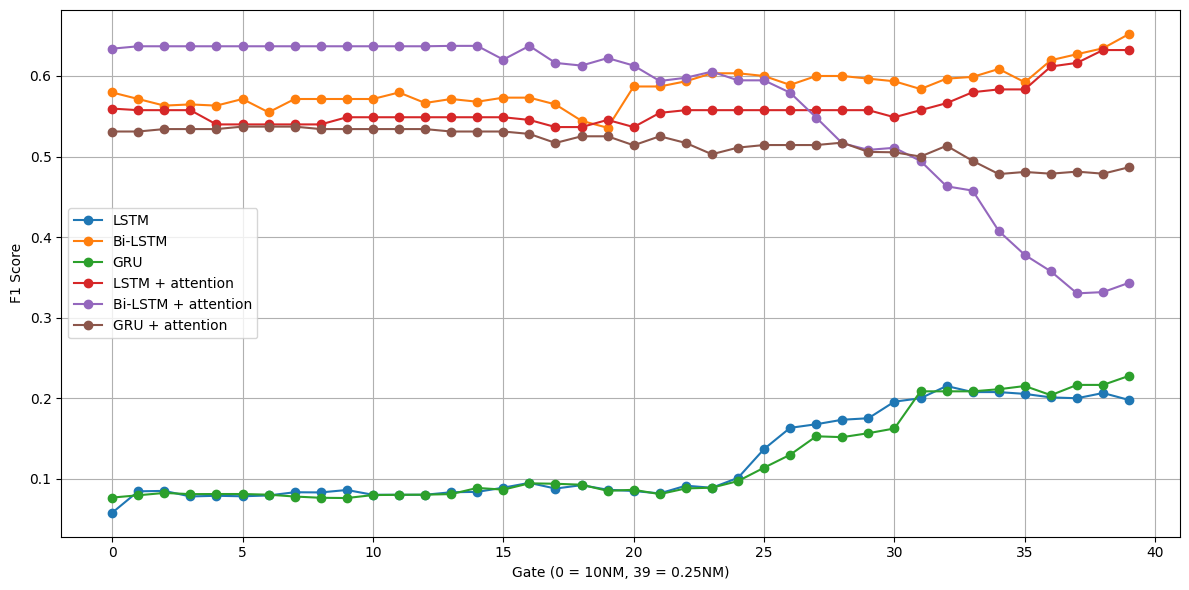

In [ ]:
#plot: model's f1 score per gate
plt.figure(figsize=(12, 6))
gates = np.arange(0, n_gates)

for name, scores in f1_model.items():
    plt.plot(gates, scores, marker='o', label=name)

plt.xlabel("Gate (0 = 10NM, 39 = 0.25NM)")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#table with examples of true positives, false positives, true negatives and false negatives
import pandas as pd
import numpy as np

model_name = "LSTM + attention"
model = models[model_name]

y_test_pred_prob = model.predict(X_test).squeeze(-1)
y_pred_bin = np.zeros_like(y_test_pred_prob, dtype=int)

for g in range(n_gates):
    threshold = best_thresholds[model_name][g]
    y_pred_bin[:, g] = (y_test_pred_prob[:, g] >= threshold).astype(int)

tp_indices = np.where((y_test_reshaped[:, :, 0].max(axis=1) == 1) & (y_pred_bin.max(axis=1) == 1))[0]
fn_indices = np.where((y_test_reshaped[:, :, 0].max(axis=1) == 1) &(y_pred_bin.max(axis=1) == 0))[0]
fp_indices = np.where((y_test_reshaped[:, :, 0].max(axis=1) == 0) &  (y_pred_bin.max(axis=1) == 1))[0]
tn_indices = np.where((y_test_reshaped[:, :, 0].max(axis=1) == 0) &(y_pred_bin.max(axis=1) == 0))[0]

n_display = 10
tp_sample = tp_indices[:n_display]
fn_sample = fn_indices[:n_display]
fp_sample = fp_indices[:n_display]
tn_sample = tn_indices[:n_display]

def create_pred_table(indices, y_pred_prob, thresholds):
    table = []
    for idx in indices:
        row = [idx]  # first column = flight index
        for g in range(n_gates):
            prob = y_pred_prob[idx, g]
            pred = int(prob >= thresholds[g])
            row.append(f"{prob:.2f} ({pred})")
        table.append(row)
    df = pd.DataFrame(table, columns=["Flight_Index"] + [f"Gate {g+1}" for g in range(n_gates)])
    return df

tp_table = create_pred_table(tp_sample, y_test_pred_prob, best_thresholds[model_name])
fn_table = create_pred_table(fn_sample, y_test_pred_prob, best_thresholds[model_name])
fp_table = create_pred_table(fp_sample, y_test_pred_prob, best_thresholds[model_name])
tn_table = create_pred_table(tn_sample, y_test_pred_prob, best_thresholds[model_name])

print("True Positives:")
display(tp_table)

print("False Negatives:")
display(fn_table)

print("False Positives:")
display(fp_table)

print("True Negatives:")
display(tn_table)

752/752 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step
True Positives:


,Flight_Index,Gate 1,Gate 2,Gate 3,Gate 4,Gate 5,Gate 6,Gate 7,Gate 8,Gate 9,...,Gate 31,Gate 32,Gate 33,Gate 34,Gate 35,Gate 36,Gate 37,Gate 38,Gate 39,Gate 40
0,1876,0.63 (1),0.64 (1),0.65 (1),0.66 (1),0.66 (1),0.66 (1),0.66 (1),0.66 (1),0.66 (1),...,0.66 (1),0.66 (1),0.66 (1),0.68 (1),0.69 (1),0.66 (1),0.84 (1),0.84 (1),0.84 (1),0.84 (1)
1,1880,0.64 (1),0.70 (1),0.72 (1),0.72 (1),0.72 (1),0.72 (1),0.72 (1),0.72 (1),0.72 (1),...,0.68 (1),0.78 (1),0.78 (1),0.78 (1),0.78 (1),0.78 (1),0.78 (1),0.78 (1),0.78 (1),0.78 (1)
2,2184,0.90 (1),0.91 (1),0.91 (1),0.91 (1),0.91 (1),0.91 (1),0.91 (1),0.91 (1),0.91 (1),...,0.93 (1),0.92 (1),0.92 (1),0.92 (1),0.92 (1),0.92 (1),0.92 (1),0.92 (1),0.92 (1),0.92 (1)
3,2389,0.76 (1),0.75 (1),0.75 (1),0.75 (1),0.75 (1),0.75 (1),0.75 (1),0.75 (1),0.75 (1),...,0.93 (1),0.93 (1),0.93 (1),0.93 (1),0.93 (1),0.93 (1),0.93 (1),0.93 (1),0.93 (1),0.93 (1)
4,2609,0.50 (1),0.50 (1),0.51 (1),0.51 (1),0.51 (0),0.51 (0),0.51 (0),0.51 (0),0.51 (0),...,0.50 (0),0.76 (1),0.76 (1),0.76 (1),0.76 (1),0.76 (1),0.76 (1),0.76 (1),0.76 (1),0.76 (1)
5,3537,0.52 (1),0.53 (1),0.53 (1),0.53 (1),0.53 (1),0.53 (1),0.53 (1),0.53 (1),0.53 (1),...,0.55 (1),0.57 (1),0.57 (1),0.57 (1),0.55 (1),0.81 (1),0.81 (1),0.81 (1),0.81 (1),0.81 (1)
6,3699,0.66 (1),0.66 (1),0.66 (1),0.66 (1),0.66 (1),0.66 (1),0.66 (1),0.66 (1),0.66 (1),...,0.66 (1),0.66 (1),0.66 (1),0.66 (1),0.67 (1),0.84 (1),0.84 (1),0.84 (1),0.84 (1),0.84 (1)
7,4184,0.79 (1),0.78 (1),0.78 (1),0.78 (1),0.78 (1),0.78 (1),0.78 (1),0.78 (1),0.78 (1),...,0.92 (1),0.92 (1),0.92 (1),0.92 (1),0.92 (1),0.92 (1),0.92 (1),0.92 (1),0.92 (1),0.92 (1)
8,4339,0.19 (0),0.19 (0),0.19 (0),0.19 (0),0.19 (0),0.19 (0),0.19 (0),0.19 (0),0.19 (0),...,0.19 (0),0.19 (0),0.20 (0),0.19 (0),0.20 (0),0.20 (0),0.20 (0),0.21 (0),0.72 (1),0.72 (1)
9,4774,0.74 (1),0.78 (1),0.78 (1),0.78 (1),0.78 (1),0.78 (1),0.78 (1),0.78 (1),0.78 (1),...,0.79 (1),0.80 (1),0.79 (1),0.79 (1),0.79 (1),0.79 (1),0.86 (1),0.86 (1),0.86 (1),0.86 (1)


False Negatives:


,Flight_Index,Gate 1,Gate 2,Gate 3,Gate 4,Gate 5,Gate 6,Gate 7,Gate 8,Gate 9,...,Gate 31,Gate 32,Gate 33,Gate 34,Gate 35,Gate 36,Gate 37,Gate 38,Gate 39,Gate 40
0,402,0.16 (0),0.17 (0),0.17 (0),0.17 (0),0.18 (0),0.18 (0),0.18 (0),0.18 (0),0.18 (0),...,0.18 (0),0.18 (0),0.18 (0),0.18 (0),0.18 (0),0.18 (0),0.18 (0),0.18 (0),0.18 (0),0.18 (0)
1,1016,0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),...,0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0)
2,1176,0.30 (0),0.30 (0),0.30 (0),0.30 (0),0.30 (0),0.30 (0),0.30 (0),0.30 (0),0.30 (0),...,0.31 (0),0.31 (0),0.31 (0),0.31 (0),0.31 (0),0.31 (0),0.31 (0),0.31 (0),0.31 (0),0.31 (0)
3,1232,0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),...,0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0)
4,1516,0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),...,0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.07 (0)
5,2792,0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),...,0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0),0.04 (0)
6,2803,0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),...,0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0)
7,3078,0.09 (0),0.09 (0),0.09 (0),0.09 (0),0.09 (0),0.09 (0),0.09 (0),0.09 (0),0.09 (0),...,0.09 (0),0.09 (0),0.09 (0),0.09 (0),0.09 (0),0.09 (0),0.09 (0),0.09 (0),0.09 (0),0.09 (0)
8,3626,0.29 (0),0.29 (0),0.29 (0),0.29 (0),0.29 (0),0.29 (0),0.29 (0),0.29 (0),0.29 (0),...,0.29 (0),0.29 (0),0.29 (0),0.29 (0),0.29 (0),0.29 (0),0.29 (0),0.29 (0),0.29 (0),0.29 (0)
9,3635,0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),...,0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0)


False Positives:


,Flight_Index,Gate 1,Gate 2,Gate 3,Gate 4,Gate 5,Gate 6,Gate 7,Gate 8,Gate 9,...,Gate 31,Gate 32,Gate 33,Gate 34,Gate 35,Gate 36,Gate 37,Gate 38,Gate 39,Gate 40
0,7687,0.51 (1),0.48 (0),0.46 (0),0.44 (0),0.44 (0),0.43 (0),0.43 (0),0.43 (0),0.43 (0),...,0.37 (0),0.37 (0),0.36 (0),0.36 (0),0.36 (0),0.35 (0),0.36 (0),0.36 (0),0.36 (0),0.36 (0)
1,8551,0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),...,0.03 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0)
2,14409,0.58 (1),0.57 (1),0.57 (1),0.57 (1),0.57 (1),0.57 (1),0.57 (1),0.57 (1),0.57 (1),...,0.57 (1),0.57 (1),0.55 (1),0.53 (1),0.56 (1),0.57 (1),0.58 (0),0.60 (1),0.61 (1),0.59 (1)
3,14632,0.60 (1),0.60 (1),0.60 (1),0.59 (1),0.59 (1),0.59 (1),0.59 (1),0.59 (1),0.59 (1),...,0.60 (1),0.61 (1),0.61 (1),0.63 (1),0.63 (1),0.63 (1),0.63 (1),0.63 (1),0.63 (1),0.63 (1)
4,15694,0.57 (1),0.57 (1),0.57 (1),0.57 (1),0.57 (1),0.57 (1),0.57 (1),0.57 (1),0.57 (1),...,0.57 (1),0.57 (1),0.58 (1),0.58 (1),0.59 (1),0.60 (1),0.61 (1),0.61 (1),0.61 (1),0.61 (1)
5,20584,0.58 (1),0.57 (1),0.56 (1),0.56 (1),0.56 (1),0.56 (1),0.56 (1),0.56 (1),0.56 (1),...,0.57 (1),0.58 (1),0.58 (1),0.58 (1),0.59 (1),0.59 (1),0.59 (1),0.59 (1),0.60 (1),0.60 (1)
6,23215,0.48 (1),0.47 (0),0.46 (0),0.46 (0),0.46 (0),0.46 (0),0.46 (0),0.46 (0),0.46 (0),...,0.48 (0),0.48 (0),0.50 (0),0.50 (1),0.50 (0),0.50 (0),0.50 (0),0.50 (0),0.50 (0),0.50 (0)


True Negatives:


,Flight_Index,Gate 1,Gate 2,Gate 3,Gate 4,Gate 5,Gate 6,Gate 7,Gate 8,Gate 9,...,Gate 31,Gate 32,Gate 33,Gate 34,Gate 35,Gate 36,Gate 37,Gate 38,Gate 39,Gate 40
0,0,0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),...,0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0),0.03 (0)
1,1,0.05 (0),0.05 (0),0.05 (0),0.05 (0),0.05 (0),0.05 (0),0.05 (0),0.05 (0),0.05 (0),...,0.05 (0),0.05 (0),0.05 (0),0.05 (0),0.05 (0),0.05 (0),0.05 (0),0.05 (0),0.05 (0),0.05 (0)
2,2,0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),...,0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0)
3,3,0.09 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),...,0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0),0.08 (0)
4,4,0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),...,0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0)
5,5,0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),...,0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0)
6,6,0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),...,0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0)
7,7,0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),...,0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0)
8,8,0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),...,0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0),0.01 (0)
9,9,0.03 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),...,0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0),0.02 (0)


In [ ]:
#find info about a true positive, false positive, true negative and false negative
tp_id = ids_test[2184]
print("True Positive flight ID:", tp_id)
df_flight = df[df["Flight_Index"] == tp_id]
date_indices = df_flight["Date"].iloc[0]
landing_indices = df_flight["Landing_Index"].unique()
icao_indices = df_flight["ICAO"].unique()
ga_indices = df_flight["Go_Around_Label"].max()
runway_indices = df_flight["Runway"].unique()
print(f"Flight {tp_id} has these landings: {landing_indices} and {icao_indices}, {ga_indices}, {date_indices}, {runway_indices}")

tn_id = ids_test[4]
print("True Negative flight ID:", tn_id)
df_flight = df[df["Flight_Index"] == tn_id]
date_indices = df_flight["Date"].iloc[0]
landing_indices = df_flight["Landing_Index"].unique()
icao_indices = df_flight["ICAO"].unique()
ga_indices = df_flight["Go_Around_Label"].max()
runway_indices = df_flight["Runway"].unique()
print(f"Flight {tn_id} has these landings: {landing_indices} and {icao_indices}, {ga_indices}, {date_indices}, {runway_indices}")

fp_id = ids_test[7687]
print("False Positive flight ID:", fp_id)
df_flight = full_df[full_df["Flight_Index"] == fp_id]
date_indices = df_flight["Date"].iloc[0]
landing_indices = df_flight["Landing_Index"].unique()
icao_indices = df_flight["ICAO"].unique()
ga_indices = df_flight["Go_Around_Label"].max()
runway_indices = df_flight["Runway"].unique()
print(f"Flight {fp_id} has these landings: {landing_indices} and {icao_indices}, {ga_indices}, {date_indices}, {runway_indices}")

fn_id = ids_test[1016]
print("False Negative flight ID:", fn_id)
df_flight = df[df["Flight_Index"] == fn_id]
date_indices = df_flight["Date"].iloc[0]
landing_indices = df_flight["Landing_Index"].unique()
icao_indices = df_flight["ICAO"].unique()
ga_indices = df_flight["Go_Around_Label"].max()
runway_indices = df_flight["Runway"].unique()
print(f"Flight {fn_id} has these landings: {landing_indices} and {icao_indices}, {ga_indices}, {date_indices}, {runway_indices}")

True Positive flight ID: 58782
Flight 58782 has these landings: [2273] and ['440daf'], 1, 2024-12-15, [2]
True Negative flight ID: 158042
Flight 158042 has these landings: [3859] and ['4951cc'], 0, 2024-03-22, [2]
False Positive flight ID: 201759
Flight 201759 has these landings: [2957] and ['49514e'], 0, 2024-11-28, [2]
False Negative flight ID: 10598
Flight 10598 has these landings: [1375] and ['4075fe'], 1, 2025-04-21, [2]


In [ ]:
#plots: flight and weather features for a a true positive, false positive, true negative and false negative

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

model_name = "LSTM + attention"
model = models[model_name]

y_test_pred_prob = model.predict(X_test).squeeze(-1) 
y_pred_bin = np.zeros_like(y_test_pred_prob, dtype=int)

for g in range(n_gates):
    threshold = best_thresholds[model_name][g]
    y_pred_bin[:, g] = (y_test_pred_prob[:, g] >= threshold).astype(int)

#examples
tp_idx = 2184
tn_idx = 4 
fp_idx = 7687 
fn_idx = 1016 

tp_seq = X_test_real[tp_idx]
tn_seq = X_test_real[tn_idx]
fn_seq = X_test_real[fn_idx]
fp_seq = X_test_real[fp_idx]

tp_mask = m_test[tp_idx]
tn_mask = m_test[tn_idx]
fn_mask = m_test[fn_idx]
fp_mask = m_test[fp_idx]

tp_seq_real = tp_seq[tp_mask==1]
tn_seq_real = tn_seq[tn_mask==1]
fn_seq_real = fn_seq[fn_mask==1]
fp_seq_real = fp_seq[fp_mask==1]

static_features = ["Wind_Speed_M", "Wind_Gust_E", "Wind_Shear_E", "C_1000_E", "C_500_E", "WS_M", "FG_M", "RA_M", "G_M", "Wind_CompU_E", "Wind_CompV_E", "LOS", "GA_before", "GA_hourly", "GA_lasttime", "Speed_Diff_lt", "Alt_Diff_lt", "Lead_Aircraft"]

dynamic_features = ["Correct Altitude", "Speed", "Vertical Rate", "Glideslope", "Deviation", "Energy"]

plt.style.use("seaborn-v0_8")
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["figure.dpi"] = 120

colors = {
    "True Positive (GA=1)":"#2ca02c",  
    "True Negative (Normal=0)":"#1f77b4", 
    "False Negative (GA=0)": "#d62728", 
    "False Positive (Normal=1)": "#ff7f0e", 
}

for feature in dynamic_features:
    feature_idx = all_features.index(feature)
    plt.figure(figsize=(10,5))
    
    plt.plot(tp_seq_real[:, feature_idx], label="True Positive (GA=1)", color=colors["True Positive (GA=1)"], linewidth=2, marker="o", markersize=4)
    plt.plot(tn_seq_real[:, feature_idx], label="True Negative (Normal=0)", color=colors["True Negative (Normal=0)"], linewidth=2, marker="s", markersize=4)
    plt.plot(fn_seq_real[:, feature_idx], label="False Negative (GA=0)", color=colors["False Negative (GA=0)"], linewidth=2, marker="^", markersize=4)
    plt.plot(fp_seq_real[:, feature_idx], label="False Positive (Normal=1)", color=colors["False Positive (Normal=1)"], linewidth=2, marker="D", markersize=4)

    plt.xlabel("Gate", fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


for feature in static_features:
    feature_idx = all_features.index(feature)

    values = {
        "True Positive (GA=1)": tp_seq_real[0, feature_idx],
        "True Negative (Normal=0)": tn_seq_real[0, feature_idx],
        "False Negative (GA=0)": fn_seq_real[0, feature_idx],
        "False Positive (Normal=1)": fp_seq_real[0, feature_idx],
    }

    plt.figure(figsize=(10,5))
    bars = plt.barh(list(values.keys()), list(values.values()), color=[colors[k] for k in values.keys()], alpha=0.85)
    
    for bar in bars:
        width = bar.get_width()
        plt.text(width * 0.95, bar.get_y() + bar.get_height()/2, f"{width:.2f}", ha="right", va="center", color="white", fontsize=10, fontweight="bold")

    plt.xlabel(feature, fontsize=12)
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
#plot: wind directions for a a true positive, false positive, true negative and false negative

import numpy as np
import matplotlib.pyplot as plt

def plot_static_wind(tp_seq_real, tn_seq_real, fn_seq_real, fp_seq_real, all_features, colors):
    windu_idx = all_features.index("Wind_CompU_E")
    windv_idx = all_features.index("Wind_CompV_E")

    winds = {
        "True Positive (GA=1)": (tp_seq_real[0, windu_idx], tp_seq_real[0, windv_idx]),
        "True Negative (Normal=0)": (tn_seq_real[0, windu_idx], tn_seq_real[0, windv_idx]),
        "False Negative (GA=0)": (fn_seq_real[0, windu_idx], fn_seq_real[0, windv_idx]),
        "False Positive (Normal=1)": (fp_seq_real[0, windu_idx], fp_seq_real[0, windv_idx]),
    }

    plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, polar=True)

    for label, (u, v) in winds.items():
        magnitude = np.sqrt(u**2 + v**2)
        angle = np.arctan2(v, u) 
        ax.bar(angle, magnitude, width=0.2, color=colors[label], alpha=0.6, label=label)

    compass_labels = ["E", "NE", "N", "NW", "W", "SW", "S", "SE"]
    ax.set_xticks(np.deg2rad(np.arange(0, 360, 45)))
    ax.set_xticklabels(compass_labels)
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)

    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.show()

if "Wind_CompU_E" in static_features and "Wind_CompV_E" in static_features:
    plot_static_wind(tp_seq_real, tn_seq_real, fn_seq_real, fp_seq_real, all_features, colors)

752/752 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step


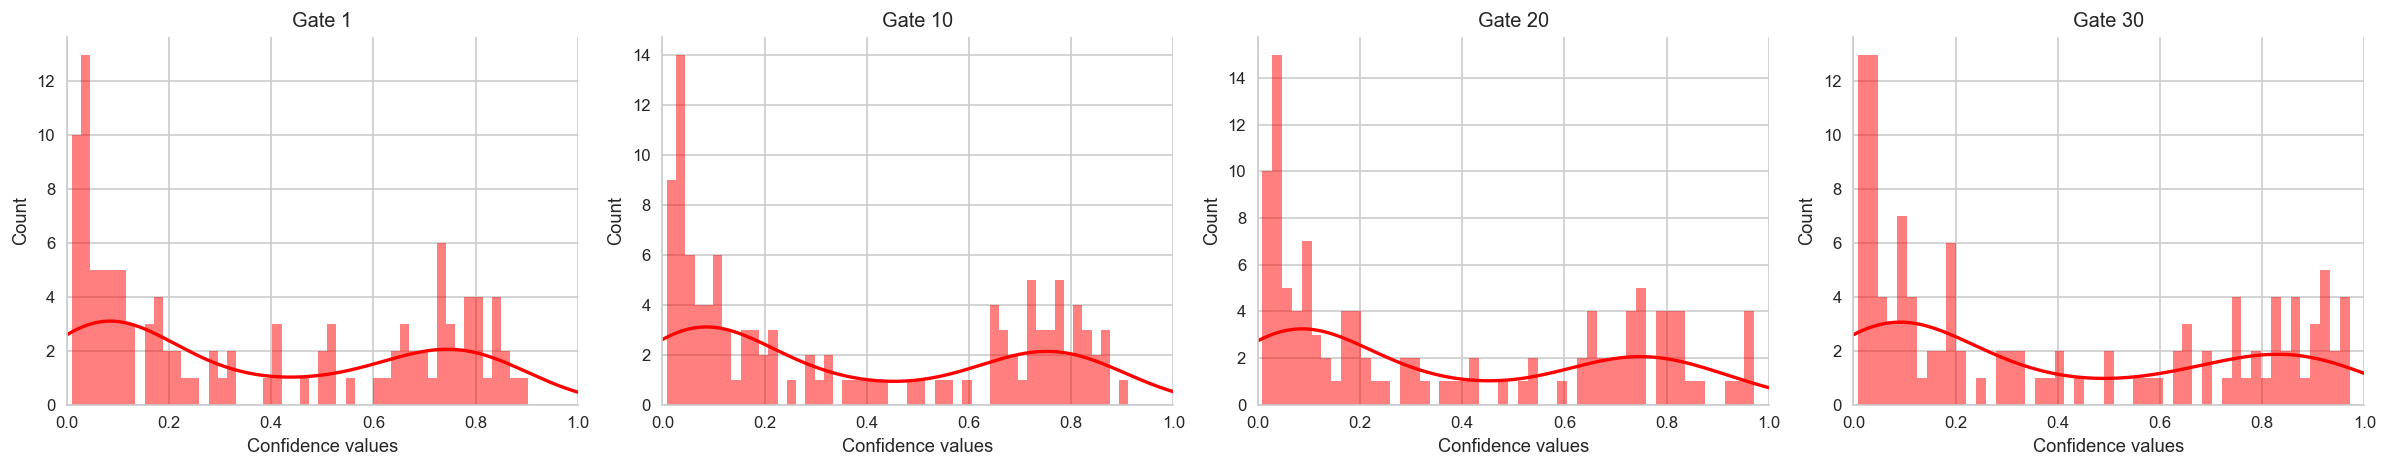

In [ ]:
#plot: go arounds' confidence values per gate 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

model_name = "LSTM + attention"
model = models[model_name]

y_test_pred_prob = model.predict(X_test).squeeze(-1) 
gates_plot = [0, 9, 19, 29]

fig, axes = plt.subplots(1, len(gates_plot), figsize=(5 * len(gates_plot), 4))
axes = np.array(axes).flatten()

for i, g in enumerate(gates_plot):
    ax = axes[i]
    probs = y_test_pred_prob[:, g]
    
    counts_ga, bins, _ = ax.hist(probs[y_test==1], bins=50, alpha=0.5, color="red")
    bin_width = bins[1] - bins[0]

    x = np.linspace(0, 1, 200)
    kde_ga = gaussian_kde(probs[y_test==1])
    ax.plot(x, kde_ga(x) * len(probs[y_test==1]) * bin_width, color="red", lw=2)

    ax.set_title(f"Gate {g+1}")
    ax.set_xlabel("Confidence values")
    ax.set_ylabel("Count")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, None)

plt.tight_layout()
plt.show()

752/752 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step


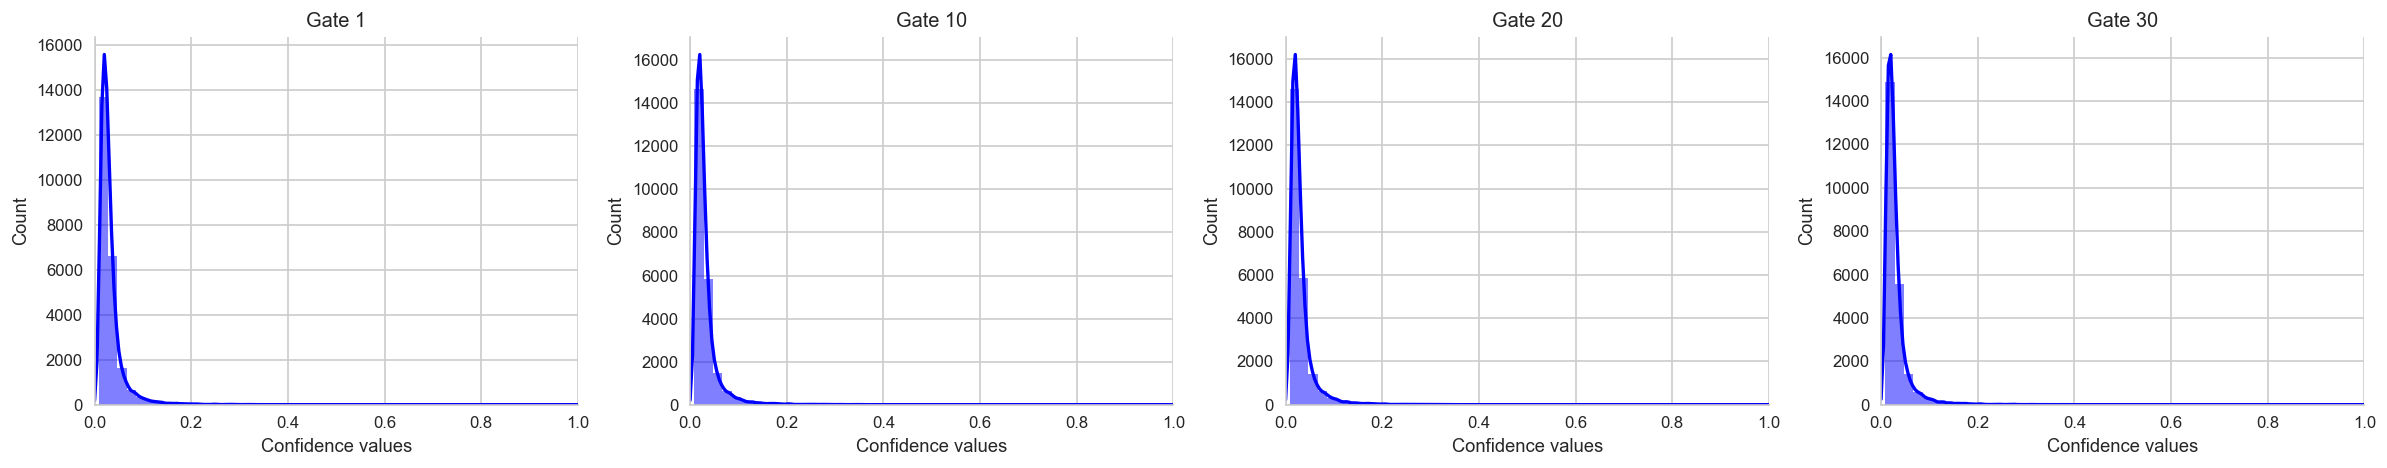

In [ ]:
#plot: normal landings' confidence values per gate
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

model_name = "LSTM + attention"
model = models[model_name]

y_test_pred_prob = model.predict(X_test).squeeze(-1) 
gates_plot = [0, 9, 19, 29]

fig, axes = plt.subplots(1, len(gates_plot), figsize=(5 * len(gates_plot), 4))
axes = np.array(axes).flatten()

for i, g in enumerate(gates_plot):
    ax = axes[i]
    probs = y_test_pred_prob[:, g]

    counts_norm, _, _ = ax.hist(probs[y_test==0], bins=bins, alpha=0.5, color="blue")
    bin_width = bins[1] - bins[0]

    x = np.linspace(0, 1, 200)
    kde_norm = gaussian_kde(probs[y_test==0])
    ax.plot(x, kde_norm(x) * len(probs[y_test==0]) * bin_width, color="blue", lw=2)

    ax.set_title(f"Gate {g+1}")
    ax.set_xlabel("Confidence values")
    ax.set_ylabel("Count")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, None)

plt.tight_layout()
plt.show()